In [603]:
import os
import csv
import time
import numpy as np
import pandas as pd
from math import sqrt
from itertools import product
from itertools import combinations_with_replacement

In [604]:
from Ptrnet import PtrNet, Critic
from tsp_data import Tsp
import torch

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [605]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [606]:
# Initialize model
hidden_dim = 256
model = PtrNet(hidden_dim=hidden_dim).to(device)

In [607]:
model.load_state_dict(torch.load('tsp_100_model_weigths_v2.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [608]:
# Load Data

df = pd.read_csv("Block_income_population_latlong_ward_commercialv3_n100.csv")
df_school = pd.read_excel("a4_1 SchoolclipNblock.xlsx", engine='openpyxl')
df_commercial = pd.read_excel("CommercialZoneAreabyBuffer500mv2_LatLong.xlsx", engine='openpyxl')
df_commercial = df_commercial.fillna(0)
df_dist = pd.read_csv("OD_matrix_99.csv")
df_dist = df_dist.set_index(keys="Unnamed: 0")
df_dist


,C2,block1,block10,block11,block12,block13,block14,block15,block16,block17,...,block90,block91,block92,block93,block94,block95,block96,block97,block98,block99
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C2,0,8650,6842,7020,6884,6961,6919,7025,6618,6127,...,1105,846,1273,1808,3084,3583,2923,6180,4883,2473
block1,8640,0,1643,1987,2614,3037,1745,2044,2173,2673,...,7880,9184,11710,12267,12158,10740,13382,13313,12664,12973
block10,6833,1643,0,688,1615,2106,1875,1590,864,1038,...,6073,7633,9580,10137,10029,9105,10319,11678,11029,10843
block11,6691,1987,688,0,943,1053,2534,2250,1507,1357,...,5911,10222,9183,9741,9632,8708,9922,11281,10633,10447
block12,8849,2614,1615,943,0,473,3611,3327,2583,2095,...,6145,9672,8634,9191,9082,8158,9372,10731,10083,9897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
block95,3410,10782,9091,8674,8134,7716,10229,9945,9202,8703,...,4515,3864,2415,2968,575,0,1217,3195,2678,3535
block96,2750,12615,11003,10586,10046,9628,12142,11857,11114,10615,...,3855,3205,1756,2309,828,1217,0,3797,3091,3015
block97,6763,13398,11708,11291,10751,10333,12846,12562,11819,11320,...,6211,6828,4846,3657,3739,3238,3651,0,751,3397


In [609]:
# Coordinates Data

I = list(df["BlockID_Flint"])
J = ['C2']
num_I = len(I)
I_J = J+I
G = list(df_commercial["C_ID"])

I_coordinates = {}
I_coordinates_x = list(df['Lat'])
I_coordinates_y = list(df['Long'])
for i in I:
    index = I.index(i)
    I_coordinates[i] = I_coordinates_x[index], I_coordinates_y[index]

J_coordinates = {}
for j in J:
    row = df_commercial[df_commercial['C_ID'] == j] 
    latitude = row['lat'].values[0] 
    longitude = row['long'].values[0] 
    J_coordinates[j] = latitude, longitude


coordinates = dict(I_coordinates, **J_coordinates)

coordinates

{'block1': (43.070266, -83.728011),
 'block10': (43.064229, -83.716173),
 'block100': (43.005303, -83.664936),
 'block11': (43.065026, -83.710028),
 'block12': (43.067583, -83.700383),
 'block13': (43.064223, -83.699208),
 'block14': (43.056051, -83.729991),
 'block15': (43.057941, -83.726333),
 'block16': (43.057913, -83.718809),
 'block17': (43.057729, -83.711768),
 'block18': (43.057587, -83.707394),
 'block19': (43.057706, -83.702227),
 'block2': (43.071036, -83.721603),
 'block20': (43.057809, -83.697135),
 'block21': (43.052359, -83.726988),
 'block22': (43.052154, -83.717964),
 'block23': (43.048464, -83.715932),
 'block24': (43.04828, -83.727695),
 'block25': (43.04829, -83.720918),
 'block26': (43.04861, -83.702615),
 'block27': (43.05183, -83.699996),
 'block28': (43.042304, -83.72977),
 'block29': (43.042377, -83.725019),
 'block3': (43.072522, -83.716819),
 'block30': (43.042498, -83.717556),
 'block31': (43.036652, -83.724561),
 'block32': (43.035049, -83.716752),
 'block3

In [610]:
# 마지막 항목을 가져옵니다.
last_item_key, last_item_value = list(coordinates.items())[-1]

# 딕셔너리에서 마지막 항목을 삭제합니다.
del coordinates[last_item_key]

# 마지막 항목을 딕셔너리의 처음에 추가합니다.
coordinates = {last_item_key: last_item_value, **coordinates}

# 결과 확인
coordinates

# block100 삭제
del coordinates["block100"]

# 결과 확인
coordinates

{'C2': (43.012754, -83.691777),
 'block1': (43.070266, -83.728011),
 'block10': (43.064229, -83.716173),
 'block11': (43.065026, -83.710028),
 'block12': (43.067583, -83.700383),
 'block13': (43.064223, -83.699208),
 'block14': (43.056051, -83.729991),
 'block15': (43.057941, -83.726333),
 'block16': (43.057913, -83.718809),
 'block17': (43.057729, -83.711768),
 'block18': (43.057587, -83.707394),
 'block19': (43.057706, -83.702227),
 'block2': (43.071036, -83.721603),
 'block20': (43.057809, -83.697135),
 'block21': (43.052359, -83.726988),
 'block22': (43.052154, -83.717964),
 'block23': (43.048464, -83.715932),
 'block24': (43.04828, -83.727695),
 'block25': (43.04829, -83.720918),
 'block26': (43.04861, -83.702615),
 'block27': (43.05183, -83.699996),
 'block28': (43.042304, -83.72977),
 'block29': (43.042377, -83.725019),
 'block3': (43.072522, -83.716819),
 'block30': (43.042498, -83.717556),
 'block31': (43.036652, -83.724561),
 'block32': (43.035049, -83.716752),
 'block33': (4

In [611]:
# 딕셔너리에서 좌표 데이터 추출
coordinates_values = [value for value in coordinates.values()]
coordinates_values

[(43.012754, -83.691777),
 (43.070266, -83.728011),
 (43.064229, -83.716173),
 (43.065026, -83.710028),
 (43.067583, -83.700383),
 (43.064223, -83.699208),
 (43.056051, -83.729991),
 (43.057941, -83.726333),
 (43.057913, -83.718809),
 (43.057729, -83.711768),
 (43.057587, -83.707394),
 (43.057706, -83.702227),
 (43.071036, -83.721603),
 (43.057809, -83.697135),
 (43.052359, -83.726988),
 (43.052154, -83.717964),
 (43.048464, -83.715932),
 (43.04828, -83.727695),
 (43.04829, -83.720918),
 (43.04861, -83.702615),
 (43.05183, -83.699996),
 (43.042304, -83.72977),
 (43.042377, -83.725019),
 (43.072522, -83.716819),
 (43.042498, -83.717556),
 (43.036652, -83.724561),
 (43.035049, -83.716752),
 (43.045161, -83.709216),
 (43.041161, -83.708374),
 (43.037385, -83.708553),
 (43.033652, -83.708651),
 (43.043493, -83.696817),
 (43.042254, -83.701158),
 (43.038181, -83.699574),
 (43.07333, -83.710231),
 (43.033181, -83.699895),
 (43.027419, -83.714892),
 (43.033545, -83.731674),
 (43.031015, -83.7

In [612]:
# 텐서로 변환
coordinates_tensor = torch.tensor(coordinates_values, dtype=torch.float32)

# 1차원 텐서로 변경
coordinates_tensor = coordinates_tensor.view(1, -1, 2)

# 크기를 torch.Size([1, 100, 2])로 변경
coordinates_tensor = coordinates_tensor.view(1, 100, 2)

coordinates_tensor.size

<function Tensor.size>

In [613]:
# 0~10 으로 스케일링

# tensor에서 최소값과 최대값 계산
min_value = coordinates_tensor.min()
max_value = coordinates_tensor.max()

# 스케일링 함수 정의
def scale_tensor(input_tensor, min_val, max_val):
    scaled_tensor = 10.0 * (input_tensor - min_val) / (max_val - min_val)
    return scaled_tensor

# tensor 스케일링
scaled_coordinates_tensor = scale_tensor(coordinates_tensor, min_value, max_value)

print(scaled_coordinates_tensor)
scaled_coordinates_tensor.shape

tensor([[[9.9952e+00, 3.3801e-03],
         [9.9998e+00, 5.2283e-04],
         [9.9993e+00, 1.4566e-03],
         [9.9993e+00, 1.9409e-03],
         [9.9995e+00, 2.7014e-03],
         [9.9993e+00, 2.7941e-03],
         [9.9986e+00, 3.6701e-04],
         [9.9988e+00, 6.5520e-04],
         [9.9988e+00, 1.2484e-03],
         [9.9988e+00, 1.8037e-03],
         [9.9988e+00, 2.1485e-03],
         [9.9988e+00, 2.5564e-03],
         [9.9998e+00, 1.0282e-03],
         [9.9988e+00, 2.9577e-03],
         [9.9983e+00, 6.0345e-04],
         [9.9983e+00, 1.3152e-03],
         [9.9980e+00, 1.4752e-03],
         [9.9980e+00, 5.4810e-04],
         [9.9980e+00, 1.0824e-03],
         [9.9981e+00, 2.5257e-03],
         [9.9983e+00, 2.7321e-03],
         [9.9976e+00, 3.8445e-04],
         [9.9976e+00, 7.5868e-04],
         [9.9999e+00, 1.4055e-03],
         [9.9976e+00, 1.3471e-03],
         [9.9971e+00, 7.9478e-04],
         [9.9970e+00, 1.4109e-03],
         [9.9978e+00, 2.0053e-03],
         [9.9975e+00

torch.Size([1, 100, 2])

In [614]:
_,sol = (scaled_coordinates_tensor.to(device))

In [615]:
sol


tensor([[ 0, 13, 75, 23, 71, 31,  3, 97, 72, 76, 32, 70, 25,  4, 30, 45, 44, 20,
         67, 87, 15, 57, 11, 41, 42, 37, 82, 73, 24, 81, 38, 40,  9, 12, 21, 53,
         17, 69, 99, 91, 89, 10, 64, 83, 22, 33, 39, 43, 27, 54, 84,  5, 85, 34,
          1, 19,  2, 16, 18, 62, 29, 50, 52, 92, 98, 28,  6, 80, 77, 60, 68, 47,
         14, 35, 46, 26, 74, 94, 56,  7,  8, 63, 95, 48, 58, 90, 55, 86, 66, 78,
         79, 59, 36, 65, 49, 61, 93, 88, 51, 96]], device='cuda:0')

In [616]:
scaled_coordinates_tensor.to('cuda')

tensor([[[9.9952e+00, 3.3801e-03],
         [9.9998e+00, 5.2283e-04],
         [9.9993e+00, 1.4566e-03],
         [9.9993e+00, 1.9409e-03],
         [9.9995e+00, 2.7014e-03],
         [9.9993e+00, 2.7941e-03],
         [9.9986e+00, 3.6701e-04],
         [9.9988e+00, 6.5520e-04],
         [9.9988e+00, 1.2484e-03],
         [9.9988e+00, 1.8037e-03],
         [9.9988e+00, 2.1485e-03],
         [9.9988e+00, 2.5564e-03],
         [9.9998e+00, 1.0282e-03],
         [9.9988e+00, 2.9577e-03],
         [9.9983e+00, 6.0345e-04],
         [9.9983e+00, 1.3152e-03],
         [9.9980e+00, 1.4752e-03],
         [9.9980e+00, 5.4810e-04],
         [9.9980e+00, 1.0824e-03],
         [9.9981e+00, 2.5257e-03],
         [9.9983e+00, 2.7321e-03],
         [9.9976e+00, 3.8445e-04],
         [9.9976e+00, 7.5868e-04],
         [9.9999e+00, 1.4055e-03],
         [9.9976e+00, 1.3471e-03],
         [9.9971e+00, 7.9478e-04],
         [9.9970e+00, 1.4109e-03],
         [9.9978e+00, 2.0053e-03],
         [9.9975e+00

In [617]:
def plot_tsp_solution(coords, tour):
    """
    coords: (num_cities, 2) - 각 도시의 좌표
    tour: (num_cities,) - 선택된 도시의 인덱스로 구성된 투어
    """
    num_cities = len(coords)
    
    # 경로 좌표 추출
    path_coords = [coords[int(i)] for i in tour]
    
    # 경로를 닫힌 형태로 만들기 위해 시작 도시를 경로에 추가
    path_coords.append(coords[int(tour[0].item())])
    
    # 좌표 추출
    path_x = [coord[0].item() for coord in path_coords]
    path_y = [coord[1].item() for coord in path_coords]
    
    # 그래프 그리기
    plt.figure(figsize=(10, 10))
    plt.plot(path_x, path_y, 'o-')
    plt.scatter(path_x[0], path_y[0], marker='s', color='red', label='Start')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [618]:
sol[0]

tensor([ 0, 13, 75, 23, 71, 31,  3, 97, 72, 76, 32, 70, 25,  4, 30, 45, 44, 20,
        67, 87, 15, 57, 11, 41, 42, 37, 82, 73, 24, 81, 38, 40,  9, 12, 21, 53,
        17, 69, 99, 91, 89, 10, 64, 83, 22, 33, 39, 43, 27, 54, 84,  5, 85, 34,
         1, 19,  2, 16, 18, 62, 29, 50, 52, 92, 98, 28,  6, 80, 77, 60, 68, 47,
        14, 35, 46, 26, 74, 94, 56,  7,  8, 63, 95, 48, 58, 90, 55, 86, 66, 78,
        79, 59, 36, 65, 49, 61, 93, 88, 51, 96], device='cuda:0')

In [619]:
df_dist

,C2,block1,block10,block11,block12,block13,block14,block15,block16,block17,...,block90,block91,block92,block93,block94,block95,block96,block97,block98,block99
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C2,0,8650,6842,7020,6884,6961,6919,7025,6618,6127,...,1105,846,1273,1808,3084,3583,2923,6180,4883,2473
block1,8640,0,1643,1987,2614,3037,1745,2044,2173,2673,...,7880,9184,11710,12267,12158,10740,13382,13313,12664,12973
block10,6833,1643,0,688,1615,2106,1875,1590,864,1038,...,6073,7633,9580,10137,10029,9105,10319,11678,11029,10843
block11,6691,1987,688,0,943,1053,2534,2250,1507,1357,...,5911,10222,9183,9741,9632,8708,9922,11281,10633,10447
block12,8849,2614,1615,943,0,473,3611,3327,2583,2095,...,6145,9672,8634,9191,9082,8158,9372,10731,10083,9897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
block95,3410,10782,9091,8674,8134,7716,10229,9945,9202,8703,...,4515,3864,2415,2968,575,0,1217,3195,2678,3535
block96,2750,12615,11003,10586,10046,9628,12142,11857,11114,10615,...,3855,3205,1756,2309,828,1217,0,3797,3091,3015
block97,6763,13398,11708,11291,10751,10333,12846,12562,11819,11320,...,6211,6828,4846,3657,3739,3238,3651,0,751,3397


In [620]:
# coordinates_key 추출
coordinates_keys = [keys for keys in coordinates.keys()]

In [621]:
# 경로의 총 거리 계산
total_distance = 0.0
for i in range(len(sol[0]) - 1):
    city1 = coordinates_keys[sol[0,i]]
    city2 = coordinates_keys[sol[0,i + 1]]
    distance = df_dist.loc[city1, city2]
    total_distance += distance

# 마지막 도시에서 첫 도시로 돌아가는 거리 추가
first_city = coordinates_keys[sol[0,0]]
last_city = coordinates_keys[sol[0,-1]]
total_distance += df_dist.loc[last_city, first_city]

print("총 거리:", total_distance)

총 거리: 498539.0


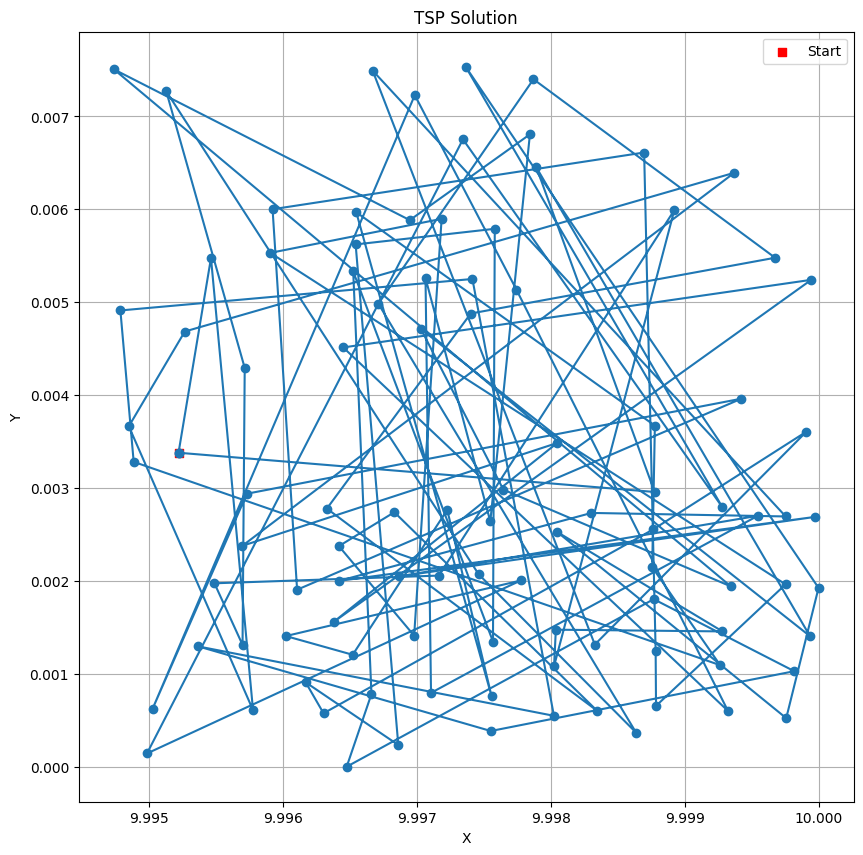

In [622]:
plot_tsp_solution(scaled_coordinates_tensor[0],sol[0])